In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from keras.layers import Dropout
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neighbors import KNeighborsClassifier


/Users/weixi/Desktop/ECE9039/ECE9039-Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = pd.read_csv('credit_card_approval.csv')
# Remove the missing values
data = data.dropna()

# Drop the ID 
data.drop('ID', axis=1, inplace=True)

# Split the data into features and target
features = data.drop('TARGET', axis=1)
target = data['TARGET']

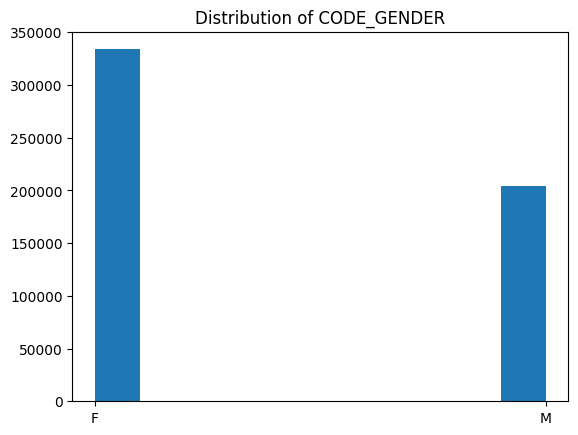

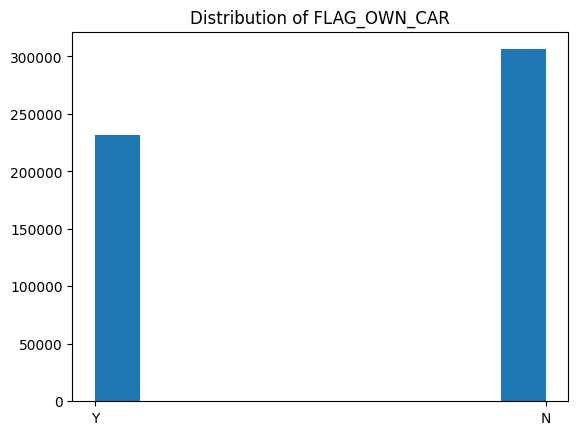

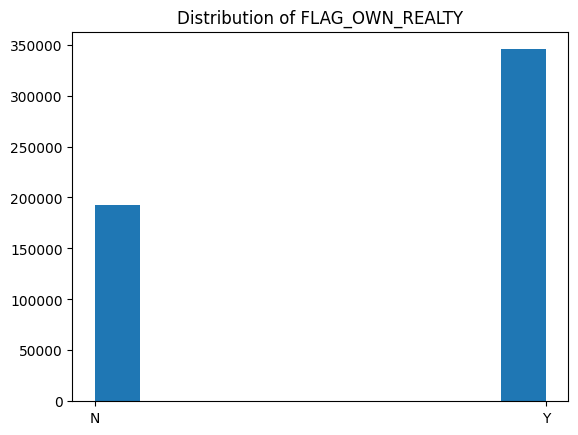

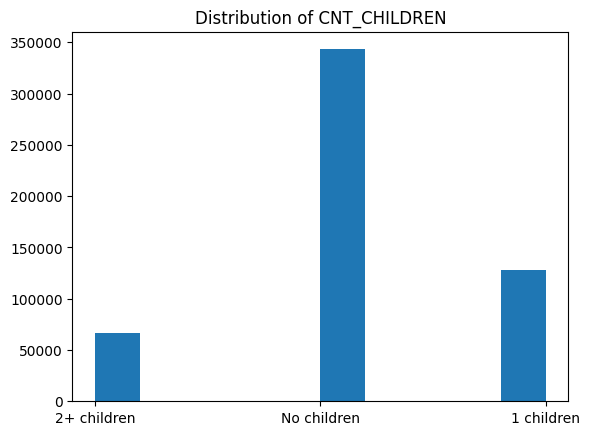

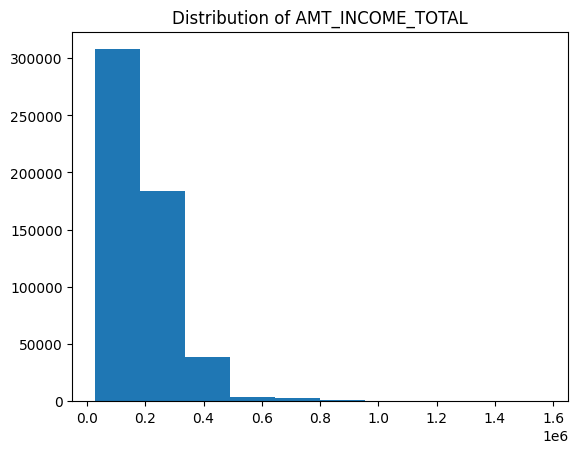

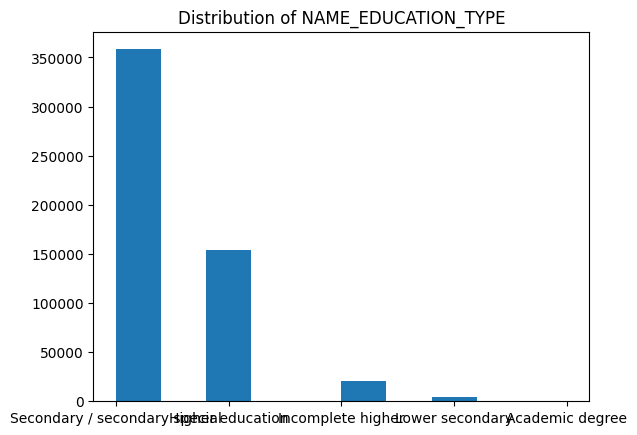

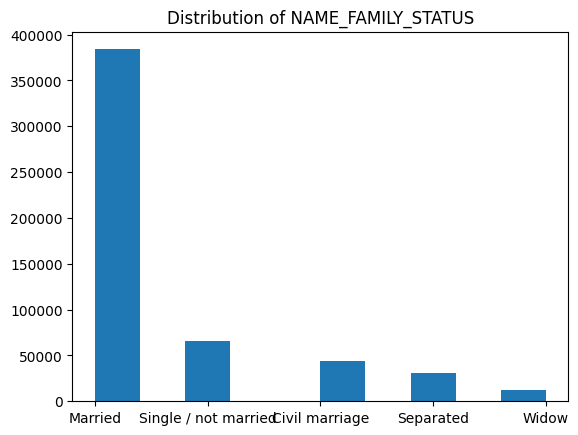

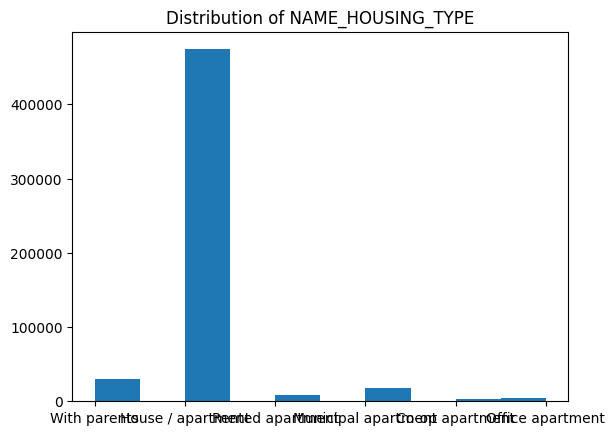

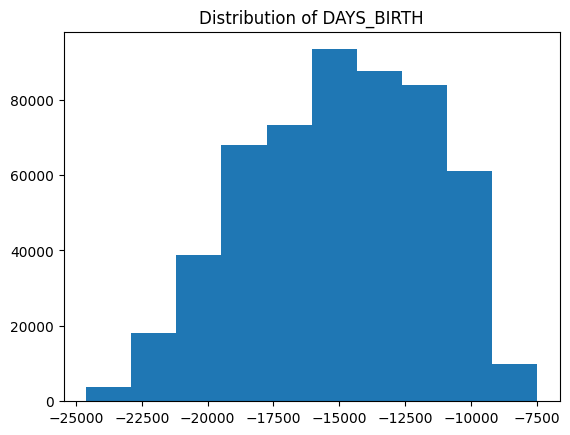

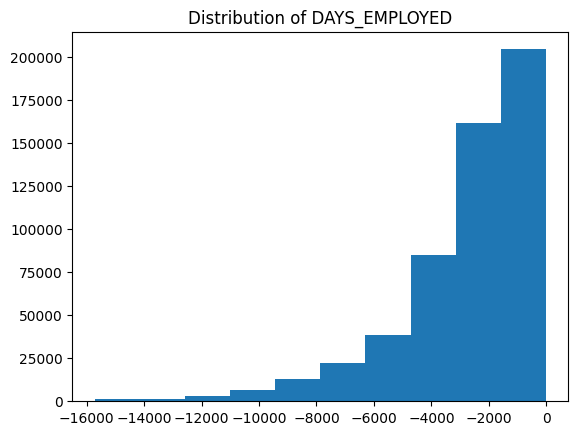

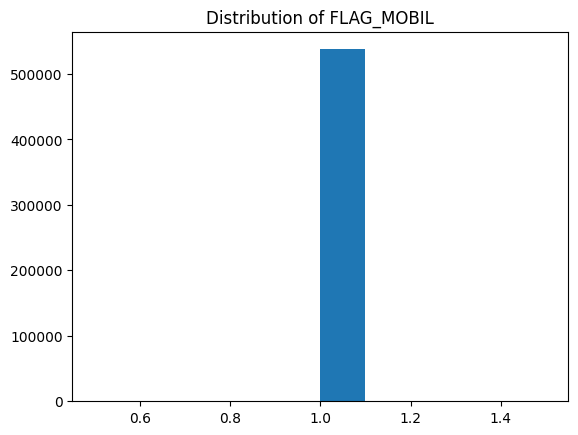

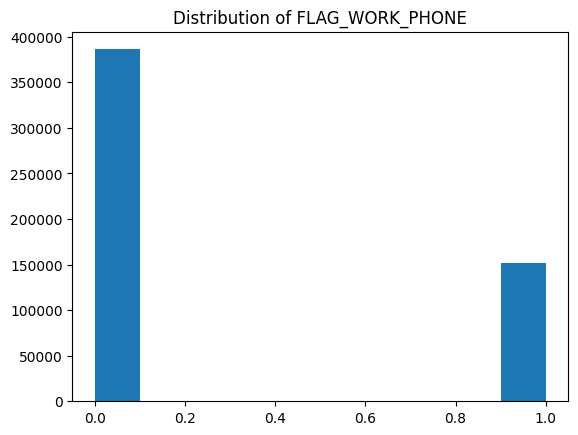

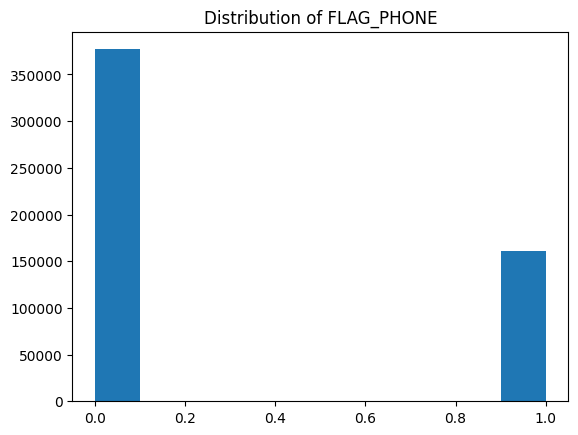

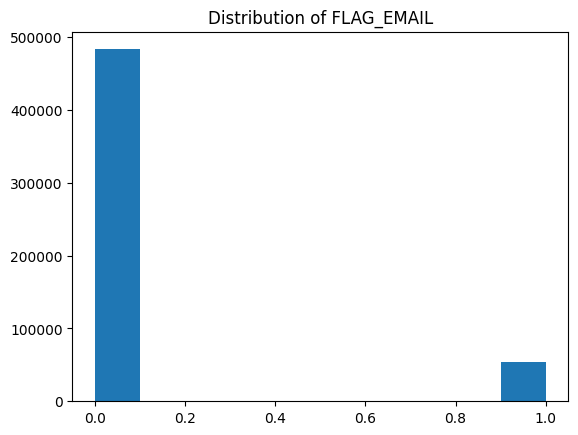

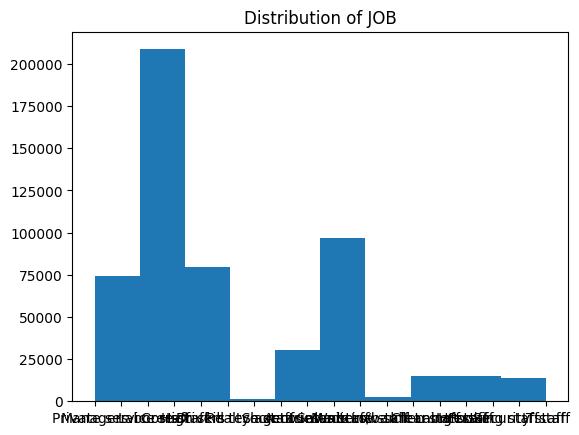

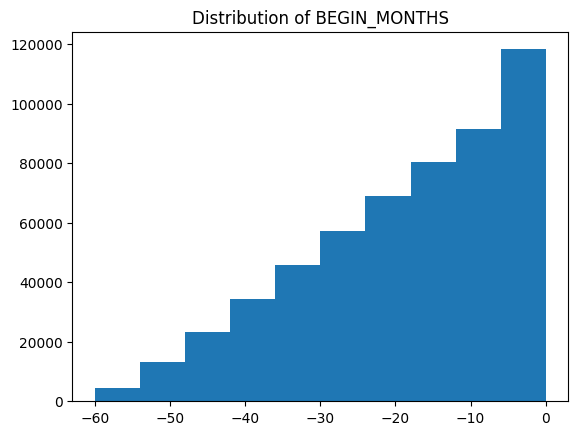

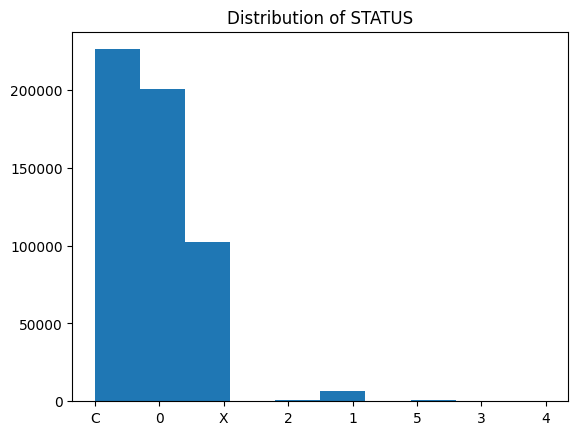

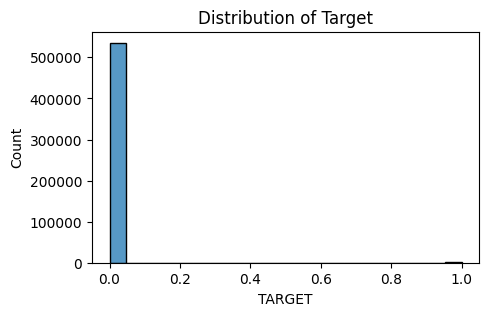

In [3]:
# Visualize the distribution of the features and target
for column in features.columns:
    plt.hist(features[column])
    plt.title(f'Distribution of {column}')
    plt.show()
plt.figure(figsize=(5, 3))
sns.histplot(target)
plt.title('Distribution of Target')
plt.show()



30 principal components that explain 80% of the variance.


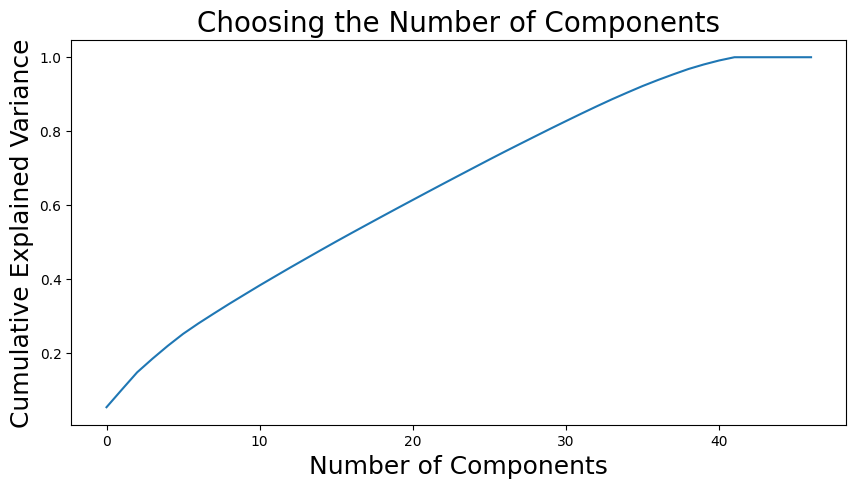

In [4]:


# print(data.head())

data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])
data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])
data['BEGIN_MONTHS'] = abs(data['BEGIN_MONTHS'])


#  Encode the gender, flag_own_car columns and flag_own_realty, F as 1, M as 0, and Y as 1, N as 0.
data['CODE_GENDER'] = data['CODE_GENDER'].map({'F': 1, 'M': 0})
data['FLAG_OWN_CAR'] = data['FLAG_OWN_CAR'].map({'Y': 1, 'N': 0})
data['FLAG_OWN_REALTY'] = data['FLAG_OWN_REALTY'].map({'Y': 1, 'N': 0})


# Preprocess the children column, replace "2+ Children" with 2, "1 Child" with 1, and "No Children" with 0.
def process_children(x):
    if 'No children' in x:
        return 0
    elif '1 children' in x:
        return 1
    elif '2+ children' in x:
        return 2  
    
    else:
        return None 
data['CNT_CHILDREN'] = data['CNT_CHILDREN'].apply(process_children)

# One-hot encode the columns NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, and JOB.
data = pd.get_dummies(data, columns=['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'JOB'])

# Defite status
status_mapping = {
    '0': 1,   # 1-29 days past due
    '1': 2,   # 30-59 days past due
    '2': 3,   # 60-89 days overdue
    '3': 4,   # 90-119 days overdue
    '4': 5,   # 120-149 days overdue
    '5': 6,   # Overdue or bad debts, write-offs for more than 150 days
    'C': 0,   # paid off that month
    'X': -1   # No loan for the month
}

data['STATUS'] = data['STATUS'].map(status_mapping)


# Split the data into features and target
features = data.drop('TARGET', axis=1)
target = data['TARGET']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA()
pca.fit(X_train)
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components',fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
ax.set_title('Choosing the Number of Components',fontsize=20)
# Determine the number of principal components that explain 80% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.8) + 1
print(f'{n_components} principal components that explain 80% of the variance.')

# Apply PCA to the data
pca = PCA(n_components=n_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)





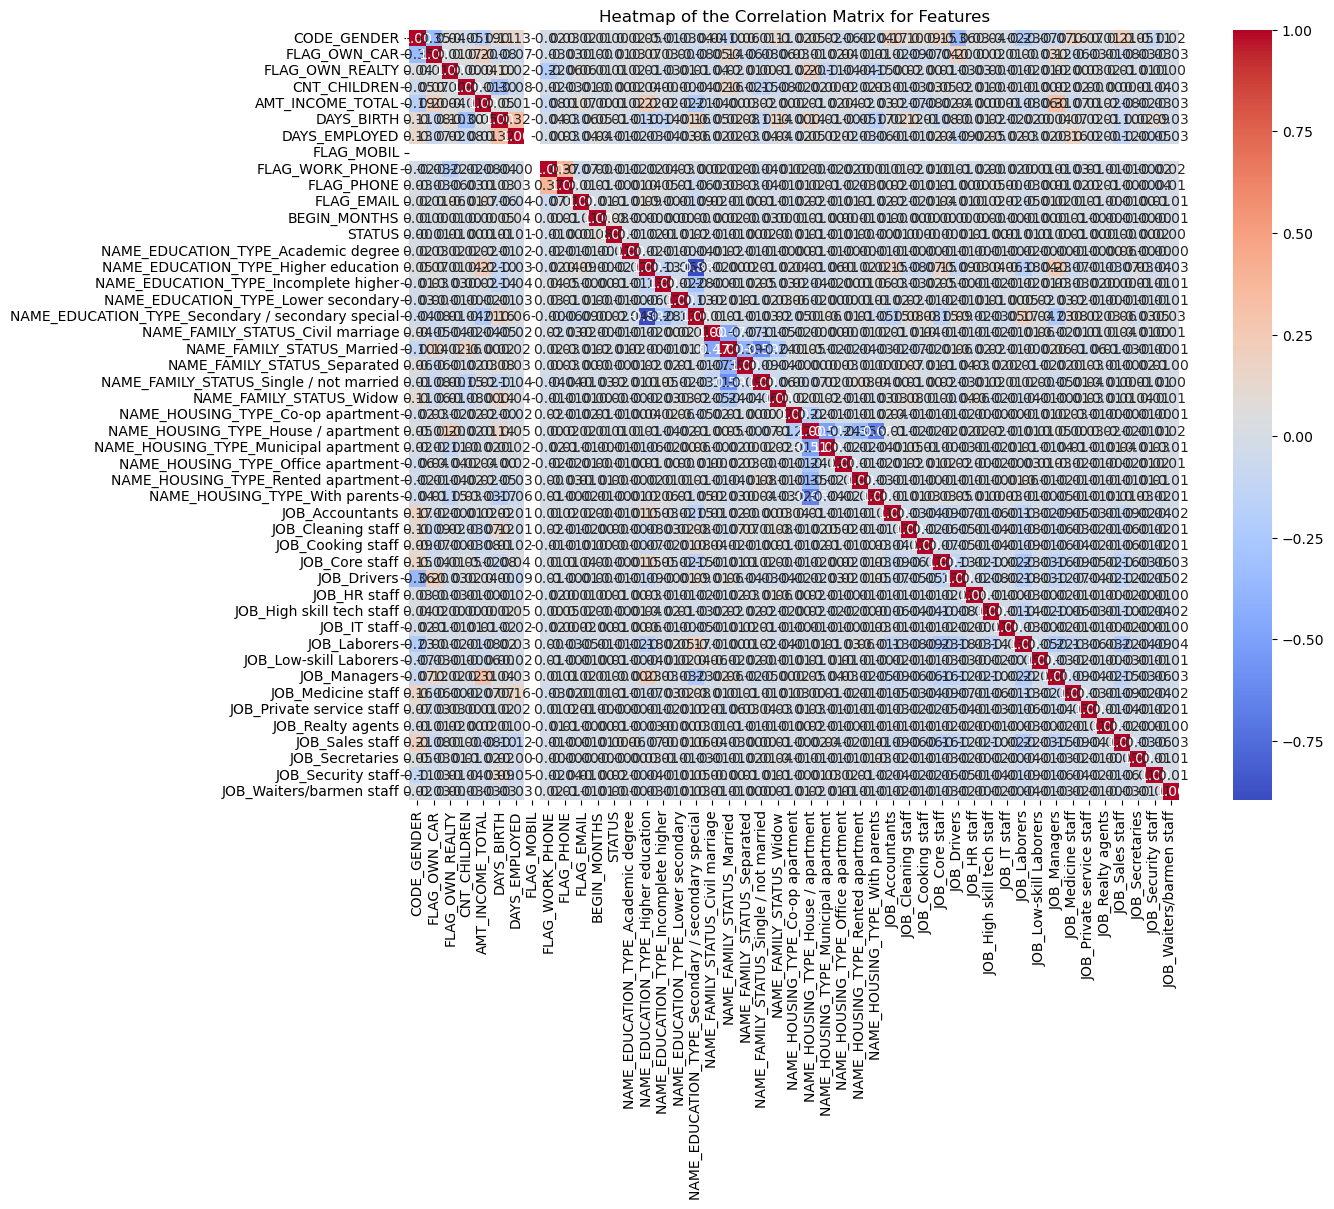

In [6]:
# Heatmap of the correlation matrix
correlation_matrix = features.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Heatmap of the Correlation Matrix for Features')
plt.show()

In [7]:


# Set MLP and cross-validation parameters
mlp = MLPClassifier(max_iter=10, random_state=42)
parameter_space = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,100)],
    'learning_rate_init': [0.001, 0.01, 0.1],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=10)
clf.fit(X_train, y_train)

# the best model parameters
print("Best parameters found:", clf.best_params_)

# Train the model using optimal parameters
best_mlp = MLPClassifier(**clf.best_params_, max_iter=10, random_state=42)
best_mlp.fit(X_train, y_train)

# Forecasting and Assessment
y_pred = best_mlp.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

c:\Users\a1007\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found: {'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001}


c:\Users\a1007\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107157
           1       0.98      0.91      0.94       377

    accuracy                           1.00    107534
   macro avg       0.99      0.95      0.97    107534
weighted avg       1.00      1.00      1.00    107534

Accuracy: 0.9996280246247699


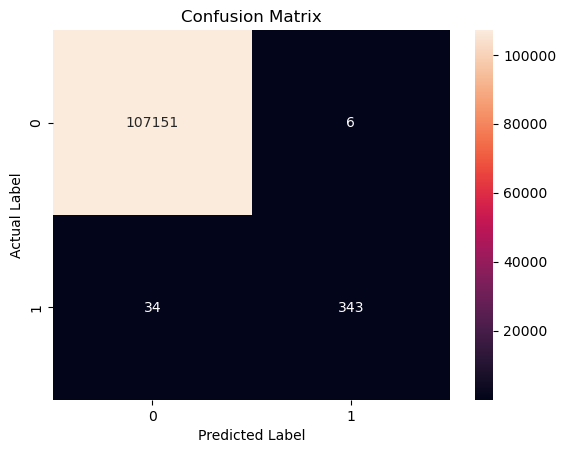

Precision: 0.9828080229226361
Recall: 0.9098143236074271
F1 Score: 0.9449035812672176
ROC-AUC Score: 0.9548791654992258


In [8]:

predictions = best_mlp.predict(X_test)
predictions_binary = (predictions > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, predictions_binary)
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

precision = precision_score(y_test, predictions_binary)
recall = recall_score(y_test, predictions_binary)
f1 = f1_score(y_test, predictions_binary)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

roc_auc = roc_auc_score(y_test, predictions)
print("ROC-AUC Score:", roc_auc)

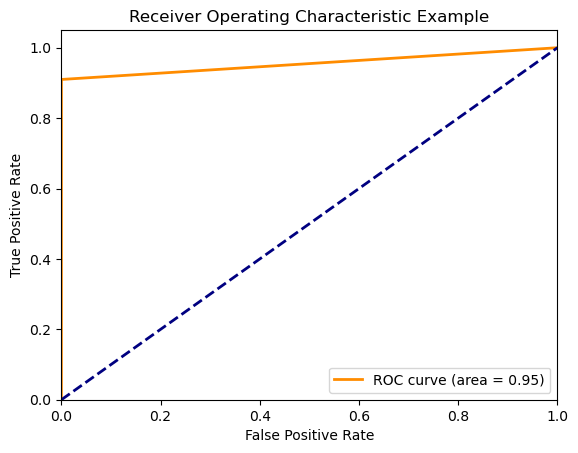

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()
precision_macro = precision_score(y_test, predictions_binary, average='macro')
recall_macro = recall_score(y_test, predictions_binary, average='macro')
f1_macro = f1_score(y_test, predictions_binary, average='macro')


precision_weighted = precision_score(y_test, predictions_binary, average='weighted')
recall_weighted = recall_score(y_test, predictions_binary, average='weighted')
f1_weighted = f1_score(y_test, predictions_binary, average='weighted')

In [10]:


# Choose a subset of the train set, pick 20% in each class.
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=0.2, stratify=y_train, random_state=42) 

# Initialize the Random Forest model
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

# Define the parameter space for Random Forest
search_space = {
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(3, 40),
    'min_samples_split': Integer(2, 30),
    'min_samples_leaf': Integer(1, 30),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['gini', 'entropy'])
}

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the BayesSearchCV object with 5-fold cross-validation
bayes_cv_tuner = BayesSearchCV(
    estimator = rf,
    search_spaces = search_space,
    scoring = 'accuracy',
    cv = kf,
    n_iter = 20,  
    n_jobs = -1,   
    return_train_score = True,
    refit = True, 
    random_state = 42
)

# Run the Bayesian optimization search
bayes_cv_tuner.fit(X_sample, y_sample)

# Print the best parameters found
print(f"Best parameters found: {bayes_cv_tuner.best_params_}")

# Get the best model
best_rf_model = bayes_cv_tuner.best_estimator_



Best parameters found: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 13), ('min_samples_leaf', 12), ('min_samples_split', 4), ('n_estimators', 114)])


In [11]:
y_pred_test = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107157
           1       0.98      0.78      0.87       377

    accuracy                           1.00    107534
   macro avg       0.99      0.89      0.93    107534
weighted avg       1.00      1.00      1.00    107534



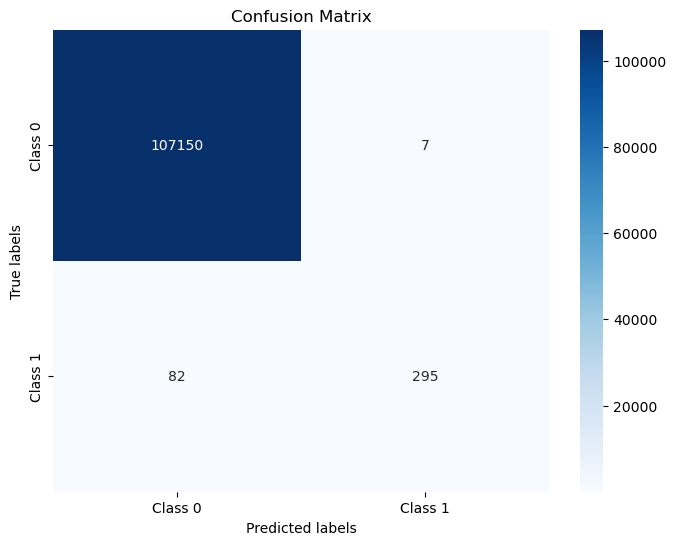

In [12]:



conf_matrix = confusion_matrix(y_test, y_pred_test)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


...Testing K =  2
...Testing K =  3
...Testing K =  4
...Testing K =  5
...Testing K =  6
...Testing K =  7
...Testing K =  8
...Testing K =  9
...Testing K =  10
...Testing K =  11
...Testing K =  12
...Testing K =  13
...Testing K =  14
...Testing K =  15
...Testing K =  16
...Testing K =  17
...Testing K =  18
...Testing K =  19
...Testing K =  20
Best K value is:  3
10-fold cross-validation scores: [0.99934905 0.99941879 0.99925606 0.99923279 0.99925604 0.99927929
 0.99944203 0.99934903 0.9990933  0.99927929]
Average cross-validation score: 0.99929556640109
Accuracy of the KNN model on the test set: 0.9992932467870627


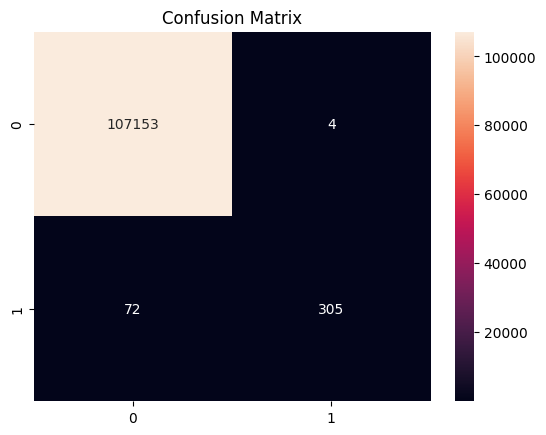

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107157
           1       0.99      0.81      0.89       377

    accuracy                           1.00    107534
   macro avg       0.99      0.90      0.94    107534
weighted avg       1.00      1.00      1.00    107534



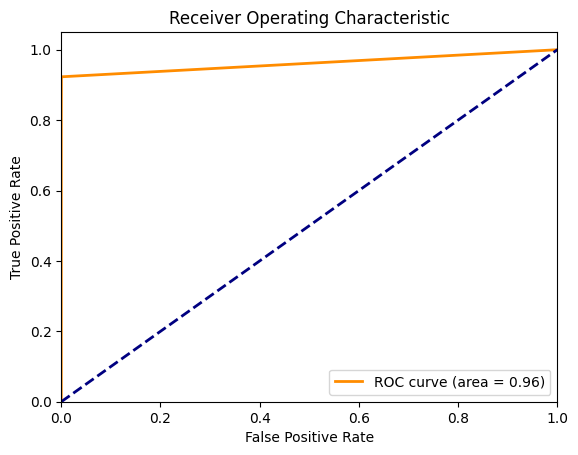

In [5]:
# KNN



# Test K value from 2 to 20
cross_val_scores = []
k_range = range(2, 21)
for k in k_range:
    print("...Testing K = ", k)
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')  # 使用10折交叉验证
    cross_val_scores.append(scores.mean())

# Find the K with highest cross validation score
best_k = k_range[cross_val_scores.index(max(cross_val_scores))]
print("Best K value is: ", best_k)

knn = KNeighborsClassifier(n_neighbors=best_k)

# 10 Fold cross validation
scores = cross_val_score(knn, X_train, y_train, cv=10)
print(f"10-fold cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

# Training
knn.fit(X_train, y_train)

# Predict in test set
y_pred = knn.predict(X_test)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the KNN model on the test set: {accuracy}")

# Show confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

# ROC Curve
if len(np.unique(y_test)) == 2:
    y_prob = knn.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()